## Import  Package

In [141]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## pre-process
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold

## models
import xgboost as xgb
from xgboost import DMatrix, XGBRegressor as XGB
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

## validation
from sklearn.metrics import f1_score
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Read Files

In [5]:
df_device = pd.read_csv('../data/rev-devices.csv')
df_notifications = pd.read_csv('../data/rev-notifications.csv')
df_transactions = pd.read_csv('../data/rev-transactions.csv')
df_users = pd.read_csv('../data/rev-users.csv')

In [6]:
df_device.head(2)

,brand,user_id
0,Android,user_3257
1,Apple,user_6809


In [14]:
df_device.brand.value_counts()

Android    9714
Apple      9673
Unknown      43
Name: brand, dtype: int64

In [7]:
df_notifications.head(2)

,reason,channel,status,user_id,created_date
0,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_7086,2018-12-02 17:58:33.320645
1,REENGAGEMENT_ACTIVE_FUNDS,PUSH,SENT,user_6598,2018-12-01 23:09:37.367127


In [16]:
df_notifications.reason.value_counts()

REENGAGEMENT_ACTIVE_FUNDS               35844
FIFTH_PAYMENT_PROMO                     23743
NO_INITIAL_CARD_USE                     11221
NO_INITIAL_CARD_ORDER                   11136
METAL_GAME_START                         8373
LOST_CARD_ORDER                          6146
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER     5459
JOINING_ANNIVERSARY                      4158
MADE_MONEY_REQUEST_NOT_SPLIT_BILL        3506
ONBOARDING_TIPS_ACTIVATED_USERS          3145
ENGAGEMENT_SPLIT_BILL_RESTAURANT         2298
BLACK_FRIDAY                             2109
METAL_RESERVE_PLAN                       1233
PREMIUM_ENGAGEMENT_INACTIVE_CARD         1124
WELCOME_HOME                              950
PUMPKIN_PAYMENT_NOTIFICATION              690
PREMIUM_ENGAGEMENT_FEES_SAVED             678
Name: reason, dtype: int64

In [17]:
df_notifications.channel.value_counts()

EMAIL    61253
PUSH     57683
SMS       2877
Name: channel, dtype: int64

In [18]:
df_notifications.status.value_counts()

SENT      89477
FAILED    32336
Name: status, dtype: int64

In [8]:
df_transactions.head(2)

,transaction_id,transactions_type,transactions_currency,amount_usd,transactions_state,ea_cardholderpresence,ea_merchant_mcc,ea_merchant_city,ea_merchant_country,direction,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,COMPLETED,NaN,NaN,NaN,NaN,OUTBOUND,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,COMPLETED,FALSE,4111.0,Dubai,ARE,OUTBOUND,user_1652,2019-03-19 06:15:59.537032


In [9]:
df_transactions['transactions_state'].value_counts()

COMPLETED    2407968
DECLINED      155286
REVERTED      112618
FAILED         41053
PENDING        21492
CANCELLED       1658
Name: transactions_state, dtype: int64

In [10]:
df_transactions['transactions_type'].value_counts()

CARD_PAYMENT    1475780
TRANSFER         500409
TOPUP            388331
EXCHANGE         159148
ATM               93675
CASHBACK          82789
FEE               23659
CARD_REFUND       11962
TAX                2829
REFUND             1493
Name: transactions_type, dtype: int64

In [11]:
df_users.head(2)

,user_id,birth_year,country,city,created_date,user_settings_crypto_unlocked,plan,attributes_notifications_marketing_push,attributes_notifications_marketing_email,num_contacts,num_referrals,num_successful_referrals
0,user_0,1989,PL,Gdansk,2018-01-13 05:15:15.599466,1,STANDARD,1.0,1.0,3,0,0
1,user_1,1975,GB,London,2018-01-29 03:38:46.676876,0,STANDARD,NaN,NaN,21,0,0


In [12]:
df_users.plan.value_counts()

STANDARD         17992
PREMIUM            865
METAL              507
METAL_FREE          37
PREMIUM_OFFER       25
PREMIUM_FREE         4
Name: plan, dtype: int64

## Part II - EDA

### a) Define a metric for user engagement.

In this case, we define an engagement indicates a user has experienced Revolut's product function in any transactions_type and the transaction_state is completed over one time as it means that a user has a completed experience in the product service after first-time use. Therefore, the definition of engagement is:

- `engaged user`: a user has over 1 transaction record and the transaction_state is COMPLETED.
- `non-engaged user`: a user has only 1 completed transaction record then churned.

In [13]:
group_user_transaction_type = df_transactions.groupby(['user_id','transactions_type']).agg({'transaction_id':'nunique'}).reset_index()

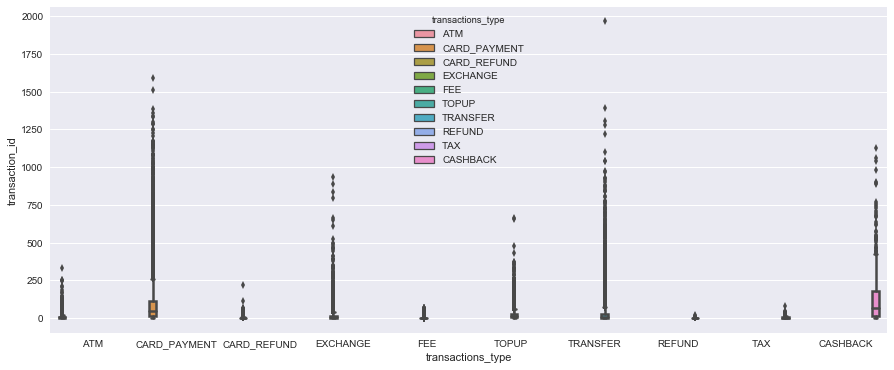

In [57]:
sns.set(rc={"figure.figsize": (15, 6)})
ax = sns.boxplot(
    x="transactions_type", y="transaction_id", hue="transactions_type",
    data = group_user_transaction_type,
    linewidth=2.5
)

In [61]:
group_user_transaction_type.groupby('transactions_type').agg({'transaction_id':['sum','mean','median']})

transaction_id                   
                             sum        mean median
transactions_type                                  
ATM                        93675    9.173032      5
CARD_PAYMENT             1475780   95.076665     44
CARD_REFUND                11962    2.804689      1
CASHBACK                   82789  133.315620     70
EXCHANGE                  159148   17.859724      7
FEE                        23659    2.303476      1
REFUND                      1493    1.407163      1
TAX                         2829    5.097297      3
TOPUP                     388331   21.109535     12
TRANSFER                  500409   38.001899      8

### b) Build up a classification model for engaged users and non-engaged users

#### b.1 transform number of  transaction type to each column and group by user_id

- to get the transaction usage from each user to measure the engagement.
- consider the transaction_state is completed only 

In [241]:
# select the transaction data with state = 'COMPLETED' and group by user_id and transaction type
group_transaction_type_by_id = df_transactions[df_transactions.transactions_state == 'COMPLETED'].groupby(
    ['user_id','transactions_type']
)['transaction_id'].nunique().reset_index()

# transform transaction type to columns for fitting into the model
group_transaction_type_by_id_pivot = pd.pivot_table(
    group_transaction_type_by_id, values=['transaction_id'], index='user_id', columns='transactions_type'
)
group_transaction_type_by_id_pivot.columns = group_transaction_type_by_id_pivot.columns.droplevel()
group_transaction_type_by_id_pivot= group_transaction_type_by_id_pivot.fillna(0)

# sum up certain transaction type by each user_id and create a new label
"""
We don't consider top-up as it's for the first time use, and some transaction types are the passive transaction 
so we don't consider as well. Therefore we consider 'CARD_PAYMENT','TRANSFER','EXCHANGE' more reflecting user active engagement
Definition: no completed transactions in these types then transaction = 0, if above one completed transaction = 1
"""
trans_type = ['CARD_PAYMENT','TRANSFER','EXCHANGE']
group_transaction_type_by_id_pivot['num_transaction'] = group_transaction_type_by_id_pivot[trans_type].sum(axis=1)
group_transaction_type_by_id_pivot['engaged'] = np.where(group_transaction_type_by_id_pivot.num_transaction == 0, 0, 1)

#### b.2 filter user features and join user data with transaction data

In [242]:
drop_cols = ['country','city','created_date']
df_user_filtered = df_users.drop(drop_cols, axis=1)

In [243]:
df_joined = group_transaction_type_by_id_pivot.join(df_user_filtered.set_index('user_id')).fillna(0)

#### b.3 Feature Engineering

- transform categorical features into label encoded features
- normalize numeric features to unify the variance.

In [244]:
df_joined_encoded = MultiColumnLabelEncoder(columns = ['plan']).fit_transform(df_joined)

In [245]:
y_col = 'engaged'
y = df_joined_encoded[[y_col]]
X = df_joined_encoded.drop(y_col, axis=1)
cols = list(X.columns)

# standardize numeric data
scaler = StandardScaler()
scaler.fit_transform(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = cols
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### b.4 XGB classification model

In [246]:
def train_xgb(train_x, train_y):
    
    # split the data 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
    
    # model parameters
    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic',
        booster='gbtree',
        colsample_bytree=0.8,
        subsample=0.5,
        learning_rate=0.05,
        max_depth=3, 
        min_child_weight=1.8,
        n_estimators=100,
        reg_alpha=0.1,
        reg_lambda=0.3,
        amma=0.01, 
        silent=1,
        random_state=5,
        nthread = -1
    )
    
    # run the model
    xgb_clf.fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae'
    )
    
    return xgb_clf

xgb_clf = train_xgb(X_train, y_train)

[0]	validation_0-mae:0.475029	validation_1-mae:0.475029
[1]	validation_0-mae:0.45136	validation_1-mae:0.45136
[2]	validation_0-mae:0.428915	validation_1-mae:0.428914
[3]	validation_0-mae:0.407623	validation_1-mae:0.407622


C:\Users\Chang_000\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Chang_000\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[4]	validation_0-mae:0.387418	validation_1-mae:0.387418
[5]	validation_0-mae:0.368242	validation_1-mae:0.368241
[6]	validation_0-mae:0.350036	validation_1-mae:0.350035
[7]	validation_0-mae:0.332749	validation_1-mae:0.332748
[8]	validation_0-mae:0.316331	validation_1-mae:0.31633
[9]	validation_0-mae:0.300737	validation_1-mae:0.300736
[10]	validation_0-mae:0.287667	validation_1-mae:0.287632
[11]	validation_0-mae:0.273506	validation_1-mae:0.273473
[12]	validation_0-mae:0.261446	validation_1-mae:0.261433
[13]	validation_0-mae:0.248593	validation_1-mae:0.248581
[14]	validation_0-mae:0.236378	validation_1-mae:0.236368
[15]	validation_0-mae:0.224768	validation_1-mae:0.224759
[16]	validation_0-mae:0.213734	validation_1-mae:0.213725
[17]	validation_0-mae:0.203247	validation_1-mae:0.203239
[18]	validation_0-mae:0.193278	validation_1-mae:0.193271
[19]	validation_0-mae:0.183803	validation_1-mae:0.183797
[20]	validation_0-mae:0.174795	validation_1-mae:0.17479
[21]	validation_0-mae:0.166233	validati

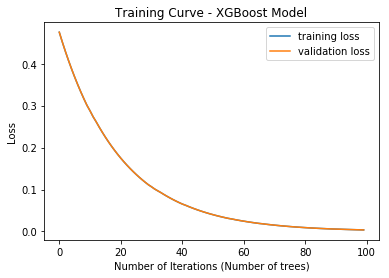

In [247]:
def plot_training_curve(clf):
    
    df_dict = {}
    for eval_set, eval_metric_dict in clf.evals_result_.items():
        for eval_metric, eval_loss in eval_metric_dict.items():
            df_dict[eval_set] = eval_loss
        
    df = pd.DataFrame(df_dict)
    return df.plot()

ax = plot_training_curve(xgb_clf)
ax.set_title('Training Curve - XGBoost Model')
ax.set_xlabel('Number of Iterations (Number of trees)')
ax.set_ylabel('Loss')

ax.legend(['training loss', 'validation loss']);

#### b.5 Prediction and Validation

It is obvious that the prediction result indicates an overfitting as only 4.5% defined non-engaged users. There are some methods we can improve it further:

- redefine non-engaged to increase the data
- compare other classification models
- feature selections
- cross-validation

Due to the time limitation for this case, we can present some improvements in the next interview.

In [248]:
y_pred = xgb_clf.predict(X_test) 
output = pd.DataFrame(y_pred).rename(columns={0:'pred_engaged'})

In [249]:
accuracy_score(y_test, y_pred, normalize=True)

1.0

In [250]:
f1_score(y_test, y_pred, average='weighted')  

1.0

In [251]:
confusion_matrix(y_test, y_pred)

array([[ 256,    0],
       [   0, 3450]], dtype=int64)

### c) How to set up a test/experiment to check whether we are reducing churn?

If we like to measure the business actions to target non-engaged users, there are some approaches can apply:

1. to measure the marketing campaigns for targeting non-engaged users to see the campaign effectiveness, we can apply `causal impact analysis` for time series data.
2. need to define `pre-intervention period` and `post-intervention period` to measure the campaign impact.
3. apply time series model to fit the pre-intervention period and forecast on post-intervention period, then compare the forecasting and actual results to measure the campaign performance.

### d) Select a metric and measure the campaign effective.

- Campaign Effect Feature:
    - `REENGAGEMENT_ACTIVE_FUNDS`

- Observed Metric:
    - `number_of_active_engaged_users` = users with one of completed `CARD_PAYMENT` or `TRANSFER` or `EXCHANGE` as these transaction type reflecting the payment behaviour, which is the engagement we expect from engaged users.

In [469]:
# get campaign data group by date
label_campaign_feature = df_notifications[(df_notifications.status == 'SENT') &
                                          (df_notifications.reason == 'REENGAGEMENT_ACTIVE_FUNDS')]
label_campaign_feature['created_date'] = pd.to_datetime(label_campaign_feature['created_date']).apply(lambda x: x.date())
campaign_label_by_date = label_campaign_feature.groupby('created_date')['reason'].count().reset_index().set_index('created_date')
campaign_label_by_date.columns=['x0']

C:\Users\Chang_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [470]:
# get completed and CARD_PAYMENT','TRANSFER','EXCHANGE' transaction type
num_transaction_for_causal_impact = df_transactions[(df_transactions.transactions_state == 'COMPLETED') &
                                                    (df_transactions.transactions_type.isin(['CARD_PAYMENT','TRANSFER','EXCHANGE']))]
num_transaction_for_causal_impact = num_transaction_for_causal_impact[['user_id','created_date']]

# group by date
num_transaction_for_causal_impact['created_date'] = pd.to_datetime(num_transaction_for_causal_impact['created_date']).apply(lambda x: x.date())
num_transaction_for_causal_impact = num_transaction_for_causal_impact.groupby('created_date')['user_id'].count().reset_index().set_index('created_date')
num_transaction_for_causal_impact.columns =['y']

In [471]:
# join campaign_label with measured metric
ci_join = num_transaction_for_causal_impact.join(campaign_label_by_date).fillna(0).reset_index()

# find out campagin start/end date and set up pre campaign period and post campaign period
start_date = ci_join.created_date.min().strftime('%Y%m%d')
campaign_label_by_date = campaign_label_by_date.reset_index()
end_date = (campaign_label_by_date.created_date.min() - datetime.timedelta(days=1)).strftime('%Y%m%d')
campaign_start_date = campaign_label_by_date.created_date.min().strftime('%Y%m%d')
campaign_end_date = campaign_label_by_date.created_date.max().strftime('%Y%m%d')

In [472]:
# fit the date index into CI model
drop_col = ['created_date']
ci_join = ci_join.drop(drop_col, axis=1)
ci_join = ci_join.set_index(
    pd.date_range(start=start_date, periods=len(ci_join))
)

In [473]:
# define pre_period = without campagin activities, post_period = starting campaign activities
pre_period = [start_date, end_date]
post_period = [campaign_start_date, campaign_end_date]

In [474]:
# run CI model
ci = CausalImpact(ci_join, pre_period, post_period)
ci.run()

C:\Users\Chang_000\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)
C:\Users\Chang_000\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


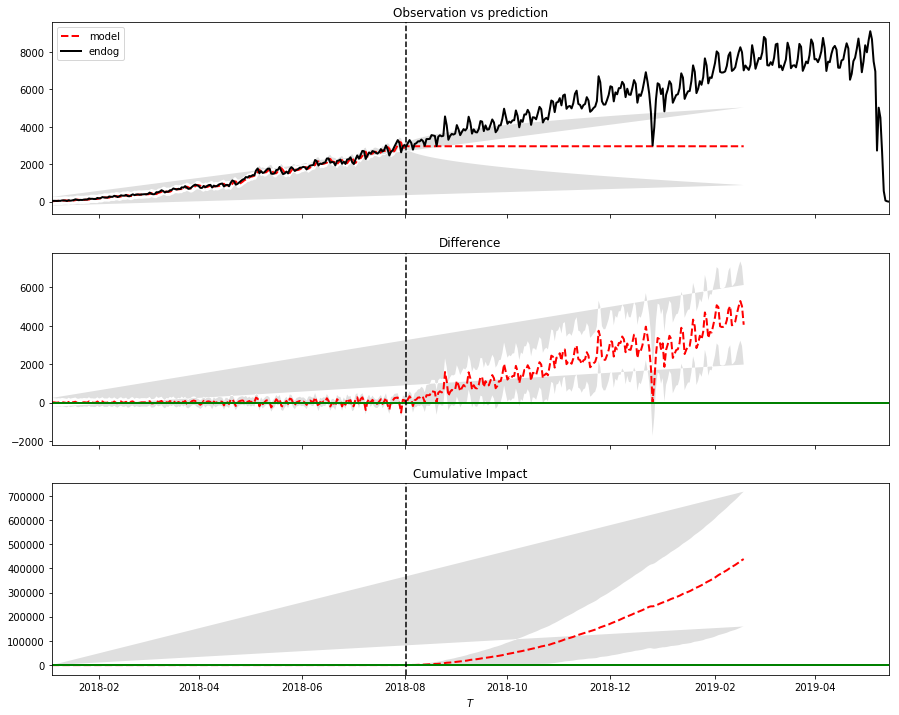

                         Average        Cumulative
Actual                      5155           1031185
Predicted                   2962            592536
95% CI              [1567, 4357]  [313595, 871477]
                                                  
Absolute Effect             2193            438648
95% CI               [3587, 798]  [717589, 159707]
                                                  
Relative Effect            74.0%             74.0%
95% CI           [121.1%, 27.0%]   [121.1%, 27.0%]
None
 During the post-intervention period, the response variable had an average value of approx. 5155.  By contrast, in  the
absence of an intervention, we would have expected an average response of 2962. The 95% interval of this counterfactual
prediction is [1567, 4357]. Subtracting this prediction from the observed response yields an estimate of the causal
effect the intervention had on the response variable. This effect is 2193 with a 95% interval of [3587, 798]. For a
discussion of

In [476]:
ci.plot()
print(ci.summary())
print(ci.summary(output='report'))